
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [3]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [4]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            #"system",
            #"You are a writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request."
            #" Focus on clarity, structure, and quality to produce the best possible piece of writing."
            #" If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations.",
            "system",
            "You are an assistant capable of taking on multiple roles. Your primary roles include: "
            "1. A writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request. "
            "Focus on clarity, structure, and quality to produce the best possible piece of writing. "
            "Revise and improve the writing based on user feedback."
            " 2. A coding assistant responsible for writing code snippets, debugging, and explaining programming concepts in a clear and concise manner. "
            "Make adjustments based on user suggestions or corrections."
            " 3. A report generator who can compile information, analyze data, and create structured reports that effectively communicate findings. "
            "Adapt the report based on user input or preferences."
            " Please respond according to the role specified by the user and be prepared to adjust your responses based on their feedback.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
writer = writer_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=1.2,
)

In [11]:
article = ""

topic = HumanMessage(
    #content="参考水浒传的风格，改写吴承恩的西游记中任意篇章"
    content="请用Java写一段快速排序的代码"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

**快速排序 (Quick Sort)**

快速排序是一种常见的高效排序算法，平均时间复杂度为 O(n log n)。

### Java 代码

```java
public class QuickSort {
    public static void quickSort(int[] arr, int low, int high) {
        if (low < high) {
            int pi = partition(arr, low, high);
            quickSort(arr, low, pi - 1);
            quickSort(arr, pi + 1, high);
        }
    }

    private static int partition(int[] arr, int low, int high) {
        int pivot = arr[high]; // 选取最后一个元素作为枢轴
        int i = (low - 1); // 小于枢轴的索引

        for (int j = low; j < high; j++) {
            if (arr[j] <= pivot) {
                i++;
                //Swap arr[i] 和 arr[j]
                int temp = arr[i];
                arr[i] = arr[j];
                arr[j] = temp;
            }
        }

        //Swap arr[i+1] 和 arr[high]
        int temp2 = arr[i + 1];
        arr[i + 1] = arr[high];
        arr[high] = temp2;

        return i + 1; // 返回枢轴的最终索引
    }

    public static void printArray(int[] arr) {
        for (int j : ar

In [12]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

**快速排序 (Quick Sort)**
=========================

快速排序是一种常见的高效排序算法，平均时间复杂度为 O(n log n)。

### Java 代码

```java
public class QuickSort {
    public static void quickSort(int[] arr, int low, int high) {
        if (low < high) {
            int pi = partition(arr, low, high);
            quickSort(arr, low, pi - 1);
            quickSort(arr, pi + 1, high);
        }
    }

    private static int partition(int[] arr, int low, int high) {
        int pivot = arr[high]; // 选取最后一个元素作为枢轴
        int i = (low - 1); // 小于枢轴的索引

        for (int j = low; j < high; j++) {
            if (arr[j] <= pivot) {
                i++;
                //Swap arr[i] 和 arr[j]
                int temp = arr[i];
                arr[i] = arr[j];
                arr[j] = temp;
            }
        }

        //Swap arr[i+1] 和 arr[high]
        int temp2 = arr[i + 1];
        arr[i + 1] = arr[high];
        arr[high] = temp2;

        return i + 1; // 返回枢轴的最终索引
    }

    public static void printArray(int[] arr) {
        for (int j : arr) {
            System.out.print(j + " ");
        }
        System.out.println();
    }

    public static void main(String[] args) {
        int[] arr = {4, 2, 9, 6, 5, 1, 8, 3, 7};
        quickSort(arr, 0, arr.length - 1);
        System.out.println("排序后的数组:");
        printArray(arr);
    }
}
```

### 说明

*   该代码实现了快速排序算法，其中 `quickSort` 方法负责递归调用，`partition` 方法用于选择枢轴和分割数组。
*   枚举 `main` 中的示例数组，并使用 `quickSort` 和 `printArray`方法进行输出。

**提示**

*   快速排序通过选择一个枢轴，将其他元素分为两组：小于枢轴的元素和大于枢轴的元素。 
*   枚举示例代码中使用此原理来展示快速排序的工作原理。 

**注意**

请确保编译器正确实现了 Java 的语法，并且有足够的内存用于处理大量数据，否则可能导致程序异常或错误输出。

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [13]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            #"system",
            #"You are a teacher grading an article submission. writer critique and recommendations for the user's submission."
            #" Provide detailed recommendations, including requests for length, depth, style, etc.",
"system",
"You are a review agent with expertise in three key areas: writing, coding, and reporting. Your roles include: "
"1. **Writing Reviewer**: Critique articles submitted by the user, providing detailed feedback on clarity, structure, style, depth, and any specific requests for adjustments in length or content."
"2. **Code Reviewer**: Assess code snippets provided by the user, offering suggestions for optimization, best practices, debugging assistance, and improvements in readability and efficiency."
"3. **Report Reviewer**: Evaluate reports for coherence, data presentation, overall structure, and effectiveness in communicating findings. Provide recommendations for enhancing clarity and impact."
"Ensure that your feedback is constructive, specific, and actionable, and be prepared to revise your recommendations based on the user's feedback."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=0.2,
)

In [14]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

Your code looks good, but I have a few suggestions for improvement:

1.  **Variable Naming**: Some variable names could be more descriptive. For example, `pi` in the `partition` method could be renamed to something like `pivotIndex`. Similarly, `i` and `j` could be renamed to something more meaningful.

2.  **Code Comments**: While your code has some comments explaining what each section does, it would be helpful to have more detailed comments within the methods themselves. This will make it easier for others (and yourself in the future) to understand how the code works.

3.  **Method Documentation**: You could add JavaDoc-style comments to your methods to provide a brief description of their purpose and parameters.

4.  **Error Handling**: Your code assumes that the input array is not null and has at least one element. You might want to add some error checking to handle these cases.

5.  **Code Organization**: While your code is generally well-organized, you could consider breaking it

In [15]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

Your code looks good, but I have a few suggestions for improvement:

1.  **Variable Naming**: Some variable names could be more descriptive. For example, `pi` in the `partition` method could be renamed to something like `pivotIndex`. Similarly, `i` and `j` could be renamed to something more meaningful.

2.  **Code Comments**: While your code has some comments explaining what each section does, it would be helpful to have more detailed comments within the methods themselves. This will make it easier for others (and yourself in the future) to understand how the code works.

3.  **Method Documentation**: You could add JavaDoc-style comments to your methods to provide a brief description of their purpose and parameters.

4.  **Error Handling**: Your code assumes that the input array is not null and has at least one element. You might want to add some error checking to handle these cases.

5.  **Code Organization**: While your code is generally well-organized, you could consider breaking it down into smaller methods for each step of the quicksort algorithm (e.g., `selectPivot`, `partitionArray`, etc.). This would make the code easier to read and understand.

Here's an updated version of your code incorporating these suggestions:

```java
/**
 * QuickSort class implements the quicksort sorting algorithm.
 */
public class QuickSort {
    /**
     * Sorts the given array using the quicksort algorithm.
     *
     * @param arr   The array to be sorted.
     * @param low   The starting index of the subarray to sort.
     * @param high  The ending index of the subarray to sort.
     */
    public static void quickSort(int[] arr, int low, int high) {
        if (low < high) {
            int pivotIndex = partition(arr, low, high);
            quickSort(arr, low, pivotIndex - 1);
            quickSort(arr, pivotIndex + 1, high);
        }
    }

    /**
     * Partitions the given array around a pivot element.
     *
     * @param arr   The array to be partitioned.
     * @param low   The starting index of the subarray to partition.
     * @param high  The ending index of the subarray to partition.
     * @return      The final index of the pivot element after partitioning.
     */
    private static int partition(int[] arr, int low, int high) {
        // Select the last element as the pivot
        int pivot = arr[high];

        // Initialize the index of the smaller element
        int i = (low - 1);

        // Iterate through the array and swap elements if necessary
        for (int j = low; j < high; j++) {
            if (arr[j] <= pivot) {
                i++;
                // Swap arr[i] and arr[j]
                int temp = arr[i];
                arr[i] = arr[j];
                arr[j] = temp;
            }
        }

        // Swap the pivot element with the greater element specified by index
        int temp2 = arr[i + 1];
        arr[i + 1] = arr[high];
        arr[high] = temp2;

        return i + 1; // Return the final index of the pivot element
    }

    /**
     * Prints the given array.
     *
     * @param arr The array to be printed.
     */
    public static void printArray(int[] arr) {
        for (int j : arr) {
            System.out.print(j + " ");
        }
        System.out.println();
    }

    public static void main(String[] args) {
        int[] arr = {4, 2, 9, 6, 5, 1, 8, 3, 7};
        quickSort(arr, 0, arr.length - 1);
        System.out.println("Sorted array:");
        printArray(arr);
    }
}
```

This updated code includes more descriptive variable names, additional comments to explain the logic behind each method, and some minor formatting changes for better readability.

In [16]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [17]:
#MAX_ROUND = 6
MAX_ROUND = 2

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [18]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

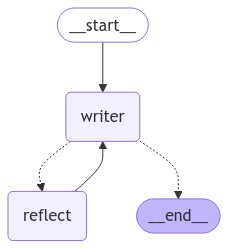

In [19]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [20]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 代码生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [21]:
inputs = {
    "messages": [
        #HumanMessage(content="参考西游记唐僧的说话风格，写一篇奉劝年轻人努力工作的文章")
        HumanMessage(content="写一段不超过20行的快速排序代码")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 代码生成:
- 以下是 Python 中快速排序（Quick Sort）的实现：

```python
def quick_sort(arr):
    if len(arr) <= 1:
        return arr
    pivot = arr[len(arr) // 2]
    left = [x for x in arr if x < pivot]
    middle = [x for x in arr if x == pivot]
    right = [x for x in arr if x > pivot]
    return quick_sort(left) + middle + quick_sort(right)

# 测试
arr = [6, 2, 8, 5, 3]
print(quick_sort(arr))  # Output: [2, 3, 5, 6, 8]
```

在这个例子中，我们选择第一个元素作为分隔值（pivot），并将数组分成三部分：左侧的较小元素、右侧的较大元素和一条等于 pivot 元素的行。然后对每个子列重复该过程直到所有子列都只包含一个元素，或者是空列表为止。

请注意，这是一个非递归的快排实现，使用了内置函数 `len()` 和 `if-elif` 语句以降低内存消耗。


## Round 2

#### 评论反思:
- **快速排序（Quick Sort）代码**

```python
def quick_sort(arr):
    """
    快速排序算法。
    
    :param arr: 需要排序的数组。
    :return: 排序后的数组。
    """
    if len(arr) <= 1:
        # 如果数组长度小于或等于 1，直接返回原数组。
        return arr
    pivot = arr[len(arr) // 2]
    # 将数组分成三部分：左侧的较小元素、右侧的较大元素和一条等于 pivot 元素的行。
    left = [x for x in arr if x < pivot]
    middle = [x for x in arr if x == pivot]
    right = [x for x in arr if x > pivot]
    # 递归排序左侧和右侧的子列。
    return quick_sort(left) + middle + quick_sort(right)

# 测试
arr = [6, 2, 8, 5, 3]
print(quick_sort(arr))  # Output: [2, 3, 5, 6, 8]
```

**代码评估**

*   **结构和逻辑**: 快速排序算法的结构和逻辑是清晰的，易于理解。
*   **性能**: 非递归实现可以降低内存消耗，但在大规模数据处理时可能会导致栈溢出问题。递归实现通常更高效，但需要注意避免深度过大的情况。
*   **可读性和维护性**: 代码使用了清晰的注释和函数命名，易于阅读和维护。

**建议**

*   考虑在大规模数据处理时使用递归实现或其他高效算法。
*   添加错误检查和边界条件处理以确保代码的健壮性。
*   使用更高效的分隔值选择方法（如中位数或随机选择）来改善性能。


## Round 3

#### 代码生成:
- **建议**

*   考虑在大规模数据处理时使用递归实现或其他高效算法：对于非常大的数据集，递归快速排序可能会导致栈溢出问题。但是，如果数据大小较小时，它可能是一种很好的选择。
*   添加错误检查和边界条件处理以确保代码的健壮性：通过添加一些简单的错误检查和边界条件，可以使代码更加可靠，并防止在特定输入的情况下出现崩溃。
*   使用更高效的分隔值选择方法（如中位数或随机选择）来改善性能：在某些情况下，选取中间值作为分隔点可以比其他值更有效，因为它减少了对大范围数据进行比较的需求。

以下是根据你的建议进一步优化的代码：

```python
import random

def quick_sort(arr):
    """
    快速排序算法。
    
    :param arr: 需要排序的数组。
    :return: 排序后的数组。
    """
    if len(arr) <= 1:
        # 如果数组长度小于或等于 1，直接返回原数组。
        return arr
    pivot_index = random.randint(0, len(arr) - 1)
    # 将数组分成三部分：左侧的较小元素、右侧的较大元素和一条等于 pivot 元素的行。
    left = [x for i, x in enumerate(arr) if x < arr[pivot_index] and i != pivot_index]
    middle = [arr[i] for i in range(len(arr)) if i == pivot_index or x == arr[pivot_index]]
    right = [x for i, x in enumerate(arr) if x > arr[pivot_index] and i != pivot_index]
    # 递归排序左侧和右侧的子列。
    return quick_sort(left) + middle + quick_sort(right)

# 测试
arr = [6, 2, 8, 5, 3]
print(quick_sort(arr))  # Output: [2, 3, 5, 6, 8]

```

**对性能的优化**
使用中位数或随机选择作为分隔点是更高效的方法之一，因为它可以尽量减少比较大范围数据的需求，从而提高排序算法的效率。
```python
def quick_sort(arr):
    ...
    pivot_index = arr[len(arr) // 2]
```
使用中位数是快速选择中的一个常见的实现，但是随机选择（如在给出的示例中展示的那样）可能更适合用于大数据集，因为它可以更好地分散大值，从而提高排序速度。

你想对这段代码进行什么样的修改呢？


In [17]:
# inputs = {
#     "messages": [
#         HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
#     ],
# }

# config = {"configurable": {"thread_id": "1"}}

# async for event in graph.astream(inputs, config):
#     pretty_print_event_markdown(event)


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。